<a href="https://colab.research.google.com/github/Loptt/CE888-Course/blob/main/lab4/my_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


df = pd.read_csv("https://raw.githubusercontent.com/albanda/CE888/master/lab4-recommender/jester-data-1.csv", header=None)
# Remove first column as it is not a rating
df_ratings = df.drop(columns=0, axis=1)
df_ratings.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
0,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,-8.50,-6.75,-7.18,8.45,-7.18,-7.52,-7.43,-9.81,-9.85,-9.85,-9.37,1.50,-4.37,-9.81,-8.50,1.12,7.82,2.86,9.13,-7.43,2.14,-4.08,-9.08,7.82,5.05,4.95,-9.17,-8.40,-8.40,-8.40,...,8.59,3.59,-6.84,-9.03,2.82,-1.36,-9.08,8.30,5.68,-4.81,99.0,99.00,99.0,99.00,99.00,99.00,99.00,-9.42,99.00,99.00,99.00,-7.72,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,2.82,99.00,99.00,99.00,99.00,99.00,-5.63,99.00,99.00,99.00
1,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,6.75,8.64,4.42,7.43,4.56,-0.97,4.66,-0.68,3.30,-1.21,0.87,8.64,8.35,9.17,0.05,7.57,4.71,0.87,-0.39,6.99,6.50,-0.92,7.14,9.03,-1.80,0.73,7.09,3.40,-0.87,7.91,...,-6.70,-3.35,-9.03,4.47,4.08,-3.83,8.74,1.12,0.78,7.52,-5.0,2.77,8.3,7.77,7.33,6.21,7.72,8.98,8.64,8.20,3.93,4.85,4.85,6.07,8.98,4.51,-0.05,3.69,4.56,0.58,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,99.00,99.00,99.00,99.00,9.03,9.27,9.03,9.27,99.00,99.00,7.33,7.57,9.37,6.17,-6.36,-6.89,-7.86,9.03,9.03,9.03,7.28,99.00,8.25,99.00,99.00,7.48,7.28,7.28,8.93,99.00,6.17,7.28,99.00,99.00,8.98,7.33,99.00,6.17,9.08,7.33,...,6.46,7.28,99.00,99.00,7.04,7.28,99.00,7.28,8.25,99.00,99.0,99.00,99.0,99.00,99.00,8.93,99.00,99.00,99.00,9.08,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,9.03,99.00,99.00,99.00,9.08,99.00,99.00,99.00,99.00,99.00,99.00
3,99.00,8.35,99.00,99.00,1.80,8.16,-2.82,6.21,99.00,1.84,7.33,6.60,6.31,8.11,-7.23,-6.65,1.17,-6.60,-3.64,-2.09,5.34,99.00,99.00,99.00,99.00,2.91,3.93,6.75,6.60,99.00,6.65,-6.12,99.00,7.57,6.21,6.65,99.00,-8.30,7.18,2.82,...,0.00,-3.69,99.00,99.00,7.82,0.24,99.00,7.28,-2.33,99.00,99.0,99.00,99.0,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,0.63,99.00,99.00,-2.33,99.00,99.00,99.00,99.00,99.00,0.53,99.00,99.00,99.00,99.00,99.00,99.00
4,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,5.73,8.25,6.84,-3.93,7.23,-2.33,-9.66,2.72,-1.36,2.57,4.51,8.20,6.12,8.30,-1.26,7.77,1.89,-1.17,5.68,8.45,4.61,8.06,-9.47,7.28,5.68,2.48,3.20,-1.26,6.80,4.51,2.48,...,7.38,6.17,4.71,-2.28,7.38,4.56,7.14,4.22,3.01,3.83,99.0,99.00,99.0,99.00,99.00,99.00,4.13,99.00,99.00,99.00,5.24,5.92,0.87,7.28,3.93,-0.63,6.31,4.71,2.82,2.96,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60


In [3]:
df_nan = df_ratings.replace(99, np.nan)
df_nan.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
0,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,-8.50,-6.75,-7.18,8.45,-7.18,-7.52,-7.43,-9.81,-9.85,-9.85,-9.37,1.50,-4.37,-9.81,-8.50,1.12,7.82,2.86,9.13,-7.43,2.14,-4.08,-9.08,7.82,5.05,4.95,-9.17,-8.40,-8.40,-8.40,...,8.59,3.59,-6.84,-9.03,2.82,-1.36,-9.08,8.30,5.68,-4.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.42,NaN,NaN,NaN,-7.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.82,NaN,NaN,NaN,NaN,NaN,-5.63,NaN,NaN,NaN
1,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,6.75,8.64,4.42,7.43,4.56,-0.97,4.66,-0.68,3.30,-1.21,0.87,8.64,8.35,9.17,0.05,7.57,4.71,0.87,-0.39,6.99,6.50,-0.92,7.14,9.03,-1.80,0.73,7.09,3.40,-0.87,7.91,...,-6.70,-3.35,-9.03,4.47,4.08,-3.83,8.74,1.12,0.78,7.52,-5.0,2.77,8.3,7.77,7.33,6.21,7.72,8.98,8.64,8.20,3.93,4.85,4.85,6.07,8.98,4.51,-0.05,3.69,4.56,0.58,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,NaN,NaN,NaN,NaN,9.03,9.27,9.03,9.27,NaN,NaN,7.33,7.57,9.37,6.17,-6.36,-6.89,-7.86,9.03,9.03,9.03,7.28,NaN,8.25,NaN,NaN,7.48,7.28,7.28,8.93,NaN,6.17,7.28,NaN,NaN,8.98,7.33,NaN,6.17,9.08,7.33,...,6.46,7.28,NaN,NaN,7.04,7.28,NaN,7.28,8.25,NaN,NaN,NaN,NaN,NaN,NaN,8.93,NaN,NaN,NaN,9.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.03,NaN,NaN,NaN,9.08,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,8.35,NaN,NaN,1.80,8.16,-2.82,6.21,NaN,1.84,7.33,6.60,6.31,8.11,-7.23,-6.65,1.17,-6.60,-3.64,-2.09,5.34,NaN,NaN,NaN,NaN,2.91,3.93,6.75,6.60,NaN,6.65,-6.12,NaN,7.57,6.21,6.65,NaN,-8.30,7.18,2.82,...,0.00,-3.69,NaN,NaN,7.82,0.24,NaN,7.28,-2.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.63,NaN,NaN,-2.33,NaN,NaN,NaN,NaN,NaN,0.53,NaN,NaN,NaN,NaN,NaN,NaN
4,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,5.73,8.25,6.84,-3.93,7.23,-2.33,-9.66,2.72,-1.36,2.57,4.51,8.20,6.12,8.30,-1.26,7.77,1.89,-1.17,5.68,8.45,4.61,8.06,-9.47,7.28,5.68,2.48,3.20,-1.26,6.80,4.51,2.48,...,7.38,6.17,4.71,-2.28,7.38,4.56,7.14,4.22,3.01,3.83,NaN,NaN,NaN,NaN,NaN,NaN,4.13,NaN,NaN,NaN,5.24,5.92,0.87,7.28,3.93,-0.63,6.31,4.71,2.82,2.96,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60


In [4]:
mean_ratings = list(enumerate(df_nan.mean(axis=0).values))
mean_ratings.sort(key=lambda x: x[1], reverse=True)
print("Best joke: {}, Rating: {:.3f}".format(mean_ratings[0][0], mean_ratings[0][1]))
print("Worst joke: {}, Rating: {:.3f}".format(mean_ratings[-1][0], mean_ratings[-1][1]))

Best joke: 49, Rating: 3.665
Worst joke: 57, Rating: -3.834


## Latent Features

In [5]:
def replace(orig, percentage=0.1):
  """
  Replaces 'percentage'% of the original values in 'orig' with 99's
  :param orig: original data array
  :param percentage: percentage of values to replace (0<percentage<1)
  """
  new_data = orig.copy()
  rated = np.asarray(new_data!=99).nonzero()
  #rated = np.where(new_data.values!=99)
  n_rated = len(rated[0])
  idx = np.random.choice(n_rated, size=int(percentage*n_rated), replace=False)
  #print(idx)
  new_data[rated[0][idx], rated[1][idx]] = 99
  return new_data, (rated[0][idx], rated[1][idx])

In [6]:
def predict_rating(user_id, item_id):
  """ Predict a rating given a user_id and an item_id.
  """
  user_preference = latent_user_preferences[user_id]
  item_preference = latent_item_features[item_id]
  return user_preference.dot(item_preference)

def train(user_id, item_id, rating, alpha=0.0001):
  #print(item_id)
  predicted_rating = predict_rating(user_id, item_id)
  err =  predicted_rating - rating
  #print(err)
  user_pref_values = latent_user_preferences[user_id]
  latent_user_preferences[user_id] -= alpha * err * latent_item_features[item_id]
  latent_item_features[item_id] -= alpha * err * user_pref_values
  return err
    

def sgd(iterations):
  """ Iterate over all users and all items and train for 
      a certain number of iterations
  """
  mse_history = []
  for iteration in range(iterations):
      error = []
      for user_id in range(latent_user_preferences.shape[0]):
          for item_id in range(latent_item_features.shape[0]):
              rating = user_ratings[user_id, item_id]
              if not np.isnan(rating):
                  err = train(user_id, item_id, rating)
                  error.append(err)
      mse = (np.array(error) ** 2).mean()   
      if (iteration % 1) == 0:
          print('Iteration %d/%d:\tMSE=%.6f' % (iteration, iterations, mse))
          mse_history.append(mse)
  return mse_history

In [8]:
new_data, val_idx = replace(df_ratings.values)
df_nan_train = pd.DataFrame(new_data).replace(99, np.nan)

In [9]:
n_latent_factors = 2

user_ratings = df_nan_train.values
# Initialise as random values
latent_user_preferences = np.random.random((user_ratings.shape[0], n_latent_factors))
latent_item_features = np.random.random((user_ratings.shape[1], n_latent_factors))

In [20]:
num_iter = 100
hist = sgd(num_iter)  # Note how the MSE decreases with the number of iterations

Iteration 0/100:	MSE=23.233376
Iteration 1/100:	MSE=23.014705
Iteration 2/100:	MSE=22.797805
Iteration 3/100:	MSE=22.582544
Iteration 4/100:	MSE=22.368254
Iteration 5/100:	MSE=22.153635
Iteration 6/100:	MSE=21.936696
Iteration 7/100:	MSE=21.714739
Iteration 8/100:	MSE=21.484442
Iteration 9/100:	MSE=21.242093
Iteration 10/100:	MSE=20.984050
Iteration 11/100:	MSE=20.707493
Iteration 12/100:	MSE=20.411418
Iteration 13/100:	MSE=20.097709
Iteration 14/100:	MSE=19.771889
Iteration 15/100:	MSE=19.443059
Iteration 16/100:	MSE=19.122681
Iteration 17/100:	MSE=18.822388
Iteration 18/100:	MSE=18.551575
Iteration 19/100:	MSE=18.315755
Iteration 20/100:	MSE=18.116214
Iteration 21/100:	MSE=17.950846
Iteration 22/100:	MSE=17.815512
Iteration 23/100:	MSE=17.705334
Iteration 24/100:	MSE=17.615575
Iteration 25/100:	MSE=17.542094
Iteration 26/100:	MSE=17.481489
Iteration 27/100:	MSE=17.431062
Iteration 28/100:	MSE=17.388713
Iteration 29/100:	MSE=17.352823
Iteration 30/100:	MSE=17.322148
Iteration 31/100:	

KeyboardInterrupt: ignored

10


ValueError: ignored

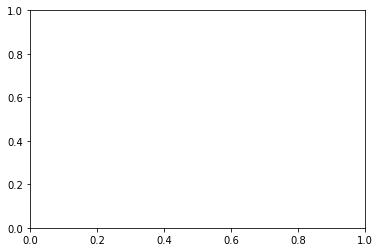

In [27]:
plt.figure()
plt.plot(np.arange(0, num_iter, 1), hist)
plt.xlabel("Iterations")
plt.ylabel("MSE")
plt.show()

## Quiz

In [17]:
df_ratings.count

<bound method DataFrame.count of          1      2      3      4     5    ...    96     97     98     99     100
0      -7.82   8.79  -9.66  -8.16 -7.52  ...  99.00  -5.63  99.00  99.00  99.00
1       4.08  -0.29   6.36   4.37 -2.38  ...  -2.14   3.06   0.34  -4.32   1.07
2      99.00  99.00  99.00  99.00  9.03  ...  99.00  99.00  99.00  99.00  99.00
3      99.00   8.35  99.00  99.00  1.80  ...  99.00  99.00  99.00  99.00  99.00
4       8.50   4.61  -4.17  -5.39  1.36  ...   1.55   3.11   6.55   1.80   1.60
...      ...    ...    ...    ...   ...  ...    ...    ...    ...    ...    ...
24978   0.44   7.43   9.08   2.33  3.20  ...   9.03   6.55   8.69   8.79   7.43
24979   9.13  -8.16   8.59   9.08  0.87  ...  -8.20  -7.23  -8.59   9.13   8.45
24980  99.00  99.00  99.00  99.00 -7.77  ...  99.00  99.00  99.00  99.00  99.00
24981  99.00  99.00  99.00  99.00 -9.71  ...  99.00  99.00  99.00  99.00  99.00
24982   2.43   2.67  -3.98   4.27 -2.28  ...  99.00  99.00  99.00  99.00  99.00

[24983

In [18]:
df_ratings.iloc[10449,92]

8.35

In [42]:
from google.colab import drive
drive.mount('/content/gdrive')

df_movies = pd.read_excel('/content/gdrive/My Drive/Colab Notebooks/movies_latent_factors.xlsx')
# Drop title column
df_movies = df_movies.drop(columns="Title")
df_movies.head()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


,Movie ID,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15
0,11,-1.521848,-1.038507,2.027269,0.247933,-0.594548,2.513260,-1.848910,0.476710,-0.224146,-0.760681,-0.973915,0.862379,0.403861,1.129616,-0.248806
1,12,-0.342185,-0.296586,-0.385962,2.443297,-1.097015,-0.619465,0.572887,0.329516,-0.712228,0.323554,-0.561948,-0.142405,-0.564415,0.506876,1.274993
2,13,-2.240888,-0.438815,-2.275177,0.614548,0.904469,0.711919,-0.420876,1.302036,-0.868418,-0.160122,0.633667,0.133138,-0.330276,-2.209004,-0.419092
3,14,-0.634531,2.186059,-0.066681,0.086197,0.517558,-0.185319,-0.412352,0.063841,0.075937,-0.577682,0.526803,-1.465557,-0.819682,0.549010,-0.681191
4,22,0.517348,-1.456763,0.369161,0.073903,-0.098332,-0.594722,0.828888,0.033626,-0.707414,0.717877,1.394326,-0.786986,1.429191,0.855746,-2.292566


In [43]:
df_users = pd.read_excel('/content/gdrive/My Drive/Colab Notebooks/movies_latent_factors.xlsx', sheet_name='Users')
df_users.head()

,User,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15
0,4768,-0.204024,0.161079,-0.090447,0.138495,-0.162934,0.163894,0.051502,-0.088582,0.126829,0.065967,0.085008,0.355404,0.007108,-0.118663,-0.039125
1,156,-0.189652,-0.178979,-0.091490,-0.000823,-0.032646,0.177209,-0.098123,-0.068283,-0.011575,0.120866,-0.009931,-0.048606,0.045916,0.113671,0.179873
2,5323,-0.115308,-0.090886,-0.053129,0.018472,-0.068081,-0.004828,0.113005,0.102107,0.034758,0.000693,-0.073712,-0.019460,0.108372,0.054471,-0.109552
3,174,-0.227462,-0.272532,-0.017231,0.054324,0.214755,-0.072639,-0.033122,-0.086508,-0.131479,0.180403,0.095890,-0.082396,0.036767,-0.165438,0.050692
4,4529,-0.014616,-0.102218,-0.107935,0.155784,-0.123362,-0.118228,-0.013549,-0.050622,0.058698,-0.159600,-0.142382,-0.132836,-0.039897,0.129063,0.102669


In [46]:
df_movies[df_movies["Movie ID"] == 194]["Factor5"]

25    0.585078
Name: Factor5, dtype: float64

In [47]:
df_movies[df_movies["Factor13"] <= df_movies["Factor13"].min()]

,Movie ID,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15
51,604,0.503414,-2.00445,0.001084,-2.255945,0.882547,-0.1886,-0.235434,0.570028,-3.492897,-0.312214,0.902742,-2.063318,-1.895101,0.748458,2.120907


In [63]:
user_row = df_users[df_users["User"] == 1882].values[:,1:]
user_row = user_row.reshape((len(user_row[0]),))
movies_row = df_movies[df_movies["Movie ID"] == 1572].values[:,1:]
movies_row = movies_row.reshape((len(movies_row[0]),))

print(user_row)
print(movies_row)

np.dot(user_row, movies_row)

(15,)
[ 0.86173148 -0.41514483 -0.05927904 -1.1680385  -1.10125703  0.31556112
  0.0800305  -0.04241262  1.07522119  1.13851796  0.30035219  0.25578669
  0.64344074 -0.40220097 -0.45166193]


-0.3633980867288325

In [64]:
user_row = df_users[df_users["User"] == 2848].values[:,1:]
user_row = user_row.reshape((len(user_row[0]),))
movies_row = df_movies[df_movies["Movie ID"] == 161].values[:,1:]
movies_row = movies_row.reshape((len(movies_row[0]),))

print(user_row)
print(movies_row)

np.dot(user_row, movies_row)

[-0.1132834  -0.09894174 -0.04039286  0.04218017 -0.04106782 -0.03956806
  0.01829098 -0.19125376  0.21891221  0.01726232 -0.08746813  0.03689397
  0.06710487 -0.01678022 -0.02950331]
[-0.16904785 -0.25379556 -0.70397888 -0.9885718  -0.527166   -0.81869593
  0.28318882 -0.21163967 -0.51853562  0.91189945  0.09082307  0.4844786
  0.32873412  1.62584314 -0.57532162]


0.0546088291969642

In [83]:
user_row = df_users[df_users["User"] == 3519].values[:,1:]
user_row = user_row.reshape((len(user_row[0]),))

ratings = []

for index, row in df_movies.iterrows():
  features = row.values[1:]
  id = row.values[0]

  result = np.dot(features, user_row)
  ratings.append((id, result))

ratings.sort(key=lambda x: x[1], reverse=True)
print(ratings[:3])

[(1891.0, 0.5030053382302906), (11.0, 0.48534081946461904), (1892.0, 0.4493682125756626)]


In [84]:
user_row = df_users[df_users["User"] == 4997].values[:,1:]
user_row = user_row.reshape((len(user_row[0]),))

ratings = []

for index, row in df_movies.iterrows():
  features = row.values[1:]
  id = row.values[0]

  result = np.dot(features, user_row)
  ratings.append((id, result))

ratings.sort(key=lambda x: x[1], reverse=True)
print(ratings[:2])

[(453.0, 2.6203230096438963), (2502.0, 2.3911005096559457)]
